## Template for providing an AlphaFold complex and couplings from evcouplings pipeline to generate a contact-coupling map

- receive a contact map that marks residues in a given atomic distance in the complex
    - some contacts are intramolecular only (blue)
    - others can be between homomeric chains that assemble into a higher-order structure (orange)
- intermolecular couplings between the different complex chains are plotted on the sides

Handwork must be done to tune each script to the according complex, given the different stochiometries / chain names / number of coupling files. But usually filling in the blanks and toying with should work.

In [1]:
#initialize
print('Importing libraries...')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn', turns off some warnings from pandas
%matplotlib inline

# enable svg export with editable text
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

from evcouplings.couplings import read_raw_ec_file
from evcouplings.compare import (
    pdb, DistanceMap, intra_dists,
    multimer_dists, coupling_scores_compared
)
from evcouplings.compare.pdb import ClassicPDB
from evcouplings.visualize import plot_contact_map, plot_context, complex_contact_map, find_boundaries

print('Libraries imported!')

#run a function definition script that is saved at a specified location
%run "S:/3-People/Max/8-Scripts/Jupyter Notebook scripts for structure prediction analysis/funcdef.py"

Importing libraries...
Libraries imported!
Defining functions...
Functions initalized!


# INPUT PREPARATION

In [2]:
# load pdbs and evcouplings residue couplings
# pass an input folder as a string and a list of filenames with .pdb ending

PDB_folder = "S:/3-People/Max/2-Results/Bioinformatics/EVCouplings mapped on Alphafold complexes/TT1751/PDB"
PDB_files = [
            'TT1751_dimer.pdb', 
            '1j3m_assembly_adjusted.pdb',
            '1j3m_assembly_adjusted_addhydrogen.pdb'
            ]


# specificy the chain IDs (A,B,C...) in the PDB file whose ID you want to analyze as a dictionary, 
# where the key is the PDB filename
# and the values is a list of chain name strings whose distances you want to compute as a two-element list
# e.g. PDB_files[0]:[['A','B'],['E','F']]...

# Be sure to catch all permutations of chain combinations in a multimer complex to have a symmetric plot!

chains_monomer = {
    PDB_files[0]:['A'],
    PDB_files[0]:['B'],
    PDB_files[1]:['A'],
    PDB_files[1]:['B'],
    PDB_files[2]:['A'],
    PDB_files[2]:['B']
}

chains_intra = { #for homomeric contacts
    PDB_files[0]:[
                  ['A','B'],
                  ['B','A']
                 ],
    PDB_files[1]:[
                  ['A','B'],
                  ['B','A']
                 ],
    PDB_files[2]:[
                  ['A','B'],
                  ['B','A']
                 ],
}


# pass an input folder as a string and a list of .csv files with evcouplings of the complex
# you want to use the _longrange.csv files as they exclude couplings between residues closer together than 4 residues
ecs_folder = "S:/3-People/Max/2-Results/Bioinformatics/EVcouplings of spore germination protein monomers"
ecs_files = [
            'TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv',
            'TT1751/Q84BQ8_b0.7/couplings/Q84BQ8_b0.7_CouplingScores_longrange.csv',
            'TT1751/Q84BQ8_b0.5/couplings/Q84BQ8_b0.5_CouplingScores_longrange.csv',
            'TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv',
            ]

# get the DESTINI data from Mu Gao
destini_folder = "S:/3-People/Max/2-Results/Bioinformatics/EVcouplings mapped on Alphafold complexes\TT1751"
data_destini = pd.read_csv('TT1751_destini.csv', sep=",")

# DATA LOADING AND PROCESSING

In [3]:
# load files and store in dicts with filenames as keys
PDB_list = {}
for file in PDB_files:
    PDB_list[file] = ClassicPDB.from_file(PDB_folder+'/'+file,file_format="pdb")
    
ec_list = {}
for file in ecs_files:
    ecs = pd.read_csv(ecs_folder+'/'+file)
    ec_list[file] =  ecs

In [4]:
# distance calculation in specified chain pairs - because we want to compare the DESTINI data, we use the C-beta distances this time around
def distmap_calc_CB(chain_ids,pdbstructure):
    from evcouplings.compare.pdb import ClassicPDB
    from evcouplings.compare import (
        pdb, DistanceMap, intra_dists,
        multimer_dists, coupling_scores_compared
    )
    
    chain1 = pdbstructure.get_chain(str(chain_ids[0]),0) #grab the first chain in tuple
    chain1 = chain1.filter_atoms(atom_name='CB') 
    
    if len(chain_ids) == 2: # for pairwise chain distances
        chain2 = pdbstructure.get_chain(str(chain_ids[1]),0) #grab the second chain in tuple
        chain2 = chain2.filter_atoms(atom_name='CB')

        distmap_pdb = DistanceMap.from_coords(chain1, chain2)
        
    else: #for intra-chain distances
        distmap_pdb = DistanceMap.from_coords(chain1)
        
    return distmap_pdb

monomer_distancemaps = {}
intra_distancemaps = {}

for file in PDB_files: #loop over all PDB files
    print('>'+str(file))
    for monomer in chains_monomer[file]:         
            print('Monomer chain: '+str(monomer))
            monomer_distancemaps[str(file)+'/'+str(monomer)]=distmap_calc_CB(monomer, PDB_list[str(file)]) #get distmap
            
    if str(file) in chains_intra: #loop over all chains specified if present in input
        for intra in chains_intra[file]:         
            #print('INTRA molecular chain pair: '+str(intra))
            intra_distancemaps[str(file)+'/'+''.join(intra)]=distmap_calc_CB(intra, PDB_list[str(file)]) #get distmap
            

>TT1751_dimer.pdb
Monomer chain: B
>1j3m_assembly_adjusted.pdb
Monomer chain: B
>1j3m_assembly_adjusted_addhydrogen.pdb
Monomer chain: B


In [5]:
# split the evcouplings table into intramolecular and intermolecular couplings, 
# based on which chain they belong to

intra_A = {}
#intra_B = {}
#inter = {}
for file in ecs_files: #loop over all ec tables get monomer couplings (A/B) or heteromer (A_B) couplings
    print('>'+file)
    ec_i = ec_list[file]
    ec_i['size']=ec_i['probability']
    ec = ec_i
    
    ec_A = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'A')]
#    ec_B = ec.loc[(ec['segment_i'] == ec['segment_j']) & (ec['segment_i'] == 'B_1')]
#    ec_het = ec.loc[ec['segment_i'] != ec['segment_j']]
    
    ec_A.loc[:,'size'] = rescale_size(ec_A, 'size')
#    ec_B.loc[:,'size'] = rescale_size(ec_B, 'size')
#    ec_het.loc[:,'size'] = rescale_size(ec_het, 'size')
    
    intra_A[str(file)] = ec_A
#    intra_B[str(file)] = ec_B
#    inter[str(file)] = ec_het
    


>TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv
>TT1751/Q84BQ8_b0.7/couplings/Q84BQ8_b0.7_CouplingScores_longrange.csv
>TT1751/Q84BQ8_b0.5/couplings/Q84BQ8_b0.5_CouplingScores_longrange.csv
>TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv


# This is the output of the data prep! 
### For plotting, you must now assign each coupling in the individual files the associated chain(s) and aggregate distance maps, if you are dealing with a multimeric assembly. Take a screenshot of this list and copy it to a txt file so you can easily copy out of it.
### To index, use these key values as strings to query the respective coupling files and distance maps between two chains from the according dictionaries.

In [6]:
print('\t> Coupling files for monomer A (intra_A[])')
print('\n'.join(list(intra_A.keys())))
#print('\t> Coupling files for monomer B (intra_B[])')
#print('\n'.join(list(intra_B.keys())))
#print('\t> Coupling files for A/B, (inter[])')
#print('\n'.join(list(inter.keys())))
print('\n')
print('\t> Distance matrices for monomer chains (monomer_distancemaps[])')
print('\n'.join(list(monomer_distancemaps.keys())))
print('\t> Distance matrices for intramolecular distances in chains (intra_distancemaps[]')
print('\n'.join(list(intra_distancemaps.keys())))
#print('\t> Distance matrices for intermolecular distances in chains (inter_distancemaps[])')
#print('\n'.join(list(inter_distancemaps.keys())))

	> Coupling files for monomer A (intra_A[])
TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv
TT1751/Q84BQ8_b0.7/couplings/Q84BQ8_b0.7_CouplingScores_longrange.csv
TT1751/Q84BQ8_b0.5/couplings/Q84BQ8_b0.5_CouplingScores_longrange.csv
TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv


	> Distance matrices for monomer chains (monomer_distancemaps[])
TT1751_dimer.pdb/B
1j3m_assembly_adjusted.pdb/B
1j3m_assembly_adjusted_addhydrogen.pdb/B
	> Distance matrices for intramolecular distances in chains (intra_distancemaps[]
TT1751_dimer.pdb/AB
TT1751_dimer.pdb/BA
1j3m_assembly_adjusted.pdb/AB
1j3m_assembly_adjusted.pdb/BA
1j3m_assembly_adjusted_addhydrogen.pdb/AB
1j3m_assembly_adjusted_addhydrogen.pdb/BA


# Process the DESTINI data

In [7]:
data_destini_filtered = data_destini[data_destini["Score"]>0] #get all contacts under 8 angstrom CB-CB distance
data_destini_filtered = data_destini_filtered[data_destini_filtered["Pred"]<=8] #get all contacts under 8 angstrom CB-CB distance
data_destini_filtered.rename(columns = {'Res_i':'j','Res_j':'i'}, inplace = True) #switch around to plot on top right plot corner

#add +2 to each i and j value as the TT1751 sequence for DESTINI started with the third amino acid (based on PDB 1J3M)
data_destini_filtered["i"] = data_destini_filtered["i"]+2
data_destini_filtered["j"] = data_destini_filtered["j"]+2

#filter out residues less than at least 6 amino acids apart
idx = abs(data_destini_filtered["i"]-data_destini_filtered["j"]) >= 6
data_destini_filtered = data_destini_filtered[idx]

# Prepare the plot

In [8]:
# pass the number of proteins in the plot, making an nxn grid that you have to fill with the data
num_chains = 1
# distance threshold in Angstrom for plotting
dist_thresh = 8
# probability cutoff for couplings plotting (only plot with a probability larger than this value)
Pcutoff = 0.9

In [9]:
# here you will need to add the corresponding couplings and distance maps
# use 'structure' to plot the whole thing because AlphaFold PDBs contain entire protein in our case

intraA_boundaries = boundary_returner_intra('structure',
                                     intra_A['TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv'],
                                     monomer_distancemaps['1j3m_assembly_adjusted.pdb/B']
                                     )

# Calculate the length ratios of the monomers that scale the plot axes - be sure to have all in this
monA_len = intraA_boundaries[0][1] - intraA_boundaries[0][0]

ratios = []

# you will need to append as many ratios to the list as you num_chains - then the plot automatically scales the axes on the grid
ratios.append(monA_len / (monA_len))

# Make the plot with inputs from above

Text(12.5, 110, 'plmDCA')

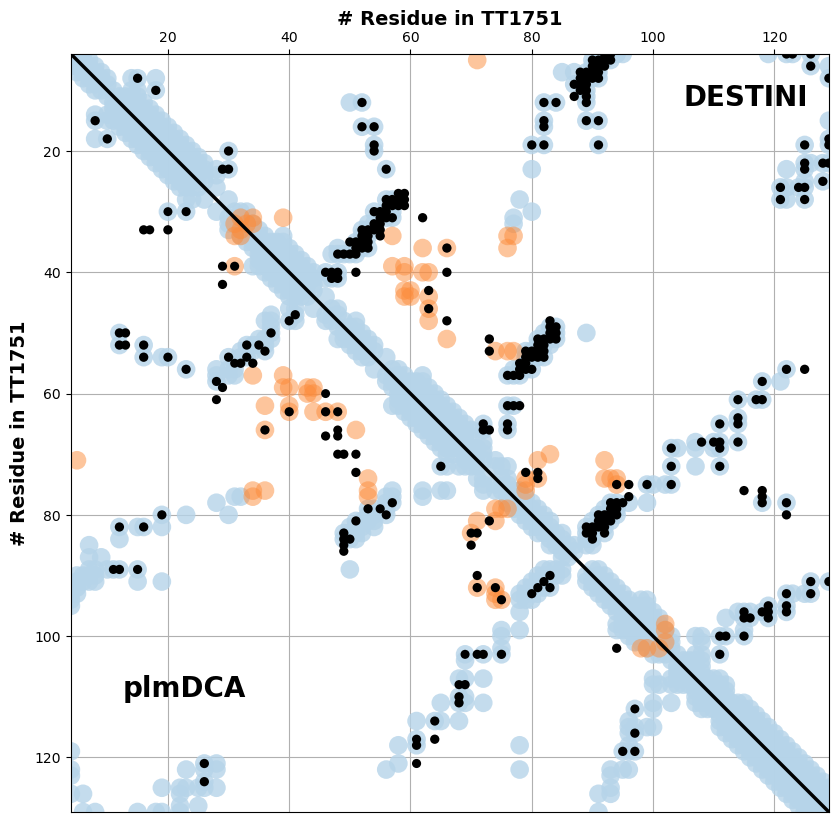

In [28]:
fig = plt.figure(figsize=(9, 9))

# create the grid for plotting
gs = gridspec.GridSpec(
        num_chains, num_chains, width_ratios=ratios,
        height_ratios=ratios
)

# create a list of axes to run through with according axes scaling
ax = [None]*num_chains**2 
for i in range(0,num_chains**2,1):
    ax[i] = plt.subplot(gs[i])
    
    ax[i].grid(True, which='major') #gridlines under plot so it's easier to trace contacts
    ax[i].set_axisbelow(True)
                        
    #ax[i].annotate('ax'+str(i),(0.5, 0.5)) #you can use this to see which ax is which
    
# format plotting by passing kwargs to function as dict
STYLE_CONTACT = {
    "edgecolor": "none",
    "c": "#b6d4e9",
    "alpha": 0.8,
    "s": 150,
}

STYLE_CONTACT_MULTIMER = {
    "edgecolor": "none",
    "c": "#fc8c3b",
    "alpha": 0.5,
    "s": 150,
}

STYLE_EC = {
    "edgecolor": "none",
    "c": "black",
    "s": 75,
}
    
# contact map plotting per each ax
# to reverse the ecs and contact maps for transposed interaction plots in the top right corners, 
# - .rename(columns={"i": "j", "j": "i"}) for the ecs
# - .transpose() the distancemap
# - list(reversed(boundaries)) to invert the axis dimensions
# - symmetric=False, multimer = None
# you can copy and paste the plots but must edit the according input data and axis information

# intramolecular couplings

plot_contact_map(
            Pthresh(intra_A['TT1751/Q84BQ8_b0.3/couplings/Q84BQ8_b0.3_CouplingScores_longrange.csv'],Pcutoff), 
            monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'],
            multimer =  DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
                                             ),
            ax=ax[0], symmetric=False, margin = 0, 
            distance_cutoff = dist_thresh, boundaries = intraA_boundaries,
            monomer_style = STYLE_CONTACT, multimer_style = STYLE_CONTACT_MULTIMER, ec_style=STYLE_EC
)

plot_contact_map(
            ecs = data_destini_filtered,
            monomer = None,
            multimer =  None,
            ax=ax[0], symmetric=False, margin = 0, 
            distance_cutoff = dist_thresh, boundaries = intraA_boundaries,
            monomer_style = STYLE_CONTACT, multimer_style = STYLE_CONTACT_MULTIMER, ec_style=STYLE_EC
)

#draw a separating line
ax[0].plot(tuple(reversed(ax[0].get_xlim())), ax[0].get_ylim(), ls="-", c="k", linewidth = 2.5)

# some custom gusto with the axis labelling
ax[0].set_xlabel('# Residue in TT1751', fontsize = 14, fontweight = 'bold')
ax[0].xaxis.set_label_position('top')
ax[0].set_ylabel('# Residue in TT1751', fontsize = 14, fontweight = 'bold')
ax[0].yaxis.set_label_position('left')

fig.tight_layout(pad = 3.0, h_pad = -1, w_pad = 1) # tight padding in plot, no big gaps

plt.text(105,12.5,'DESTINI', fontsize=20, fontweight='bold')
plt.text(12.5,110,'plmDCA', fontsize=20, fontweight='bold')

In [29]:
# save the contact map plot if it's correct :)
outpath = "S:/3-People/Max/2-Results/Bioinformatics/EVcouplings mapped on Alphafold complexes/TT1751/Plots"
filename = "TT1751_1J3M_dimer_C-beta_DESTINI_comparison.png"

fileout = outpath+'/'+filename
fig.savefig(fileout, bbox_inches='tight', dpi=300)

# score

In [130]:
monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'].dist_matrix

# number of CB-CB intramolceular contacts in structure
intra_under = monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'].dist_matrix<=dist_thresh
intra_contacts = intra_under.sum()
# number of CB-CB intermolecular contacts in structure
inter_under = DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
                                             ).dist_matrix<=dist_thresh
inter_contacts = inter_under.sum()

print(intra_contacts) #total number of intrachain contacts
print(inter_contacts) #total number of interchain contacts

# for plmDCA
Pcutoff = 0.9
tbl_dca = coupling_scores_compared(
    intra_A['TT1751/Q84BQ8_b0.8/couplings/Q84BQ8_b0.8_CouplingScores_longrange.csv'], 
    monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'], 
    dist_map_multimer = DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
    ),
    dist_cutoff=dist_thresh
)
tbl_dca = Pthresh(tbl_dca,Pcutoff) #cutoff of probability

idx_dca_intra = tbl_dca['dist_intra']<=dist_thresh
idx_dca_inter = tbl_dca['dist_multimer']<=dist_thresh

print(sum(idx_dca_intra)) #number of plmdca-identified residues pairs corresponding to intrachain contacts
print(sum(idx_dca_inter)) #number of plmdca-identified residues pairs corresponding to interchain contacts

print('Intra plmDCA [%]: '+str((sum(idx_dca_intra)/intra_contacts)*100)) #print percentage values
print('Inter plmDCA [%]: '+str((sum(idx_dca_inter)/inter_contacts)*100))

tbl_destini = coupling_scores_compared(
    data_destini_filtered, 
    monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'], 
    dist_map_multimer = DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
    ),
    dist_cutoff=dist_thresh,
    score='Score'
)

idx_destini_intra = data_destini_filtered['Label']<=8
idx_destini_inter = tbl_destini['dist_multimer']<=dist_thresh

print(sum(idx_destini_intra)) #number of contacts identified by destini corresponding to intrachain contacts in structure (according to labels in raw data)
print(sum(idx_destini_inter)) 

print('Intra DESTINI [%]: '+str((sum(idx_destini_intra)/intra_contacts)*100)) #print percentage values
print('Inter DESTINI [%]: '+str((sum(idx_destini_inter)/inter_contacts)*100))


1228
87
60
11
Intra plmDCA [%]: 4.88599348534202
Inter plmDCA [%]: 12.643678160919542
180
4
Intra DESTINI [%]: 14.65798045602606
Inter DESTINI [%]: 4.597701149425287


In [71]:
# distance threshold
dist_thresh = 8 # stringent contact distance (usually 5 angstrom)
dist_thresh_large = 12 # maximum distance to consider something a contact (usually 8 angstrom)

# distancemap for plotting
agg_intra_distancemapA = DistanceMap.aggregate(
                intra_distancemaps['1j3m_assembly_adjusted.pdb/AB'],
                intra_distancemaps['1j3m_assembly_adjusted.pdb/BA']
)

data_destini_filtered.rename(columns = {'i':'j','j':'i'}, inplace = True) #switch around to plot on top right plot corner
data_destini_filtered

# add the computed distances to the coupling table and plot the data
tbl_cc = coupling_scores_compared(
    data_destini_filtered, 
    monomer_distancemaps['1j3m_assembly_adjusted.pdb/B'], 
    dist_map_multimer = agg_intra_distancemapA,
    dist_cutoff=dist_thresh,
    score='Score'
)

tbl_cc

,i,j,Score,Pred,Label,0-4.5A,4.5-5A,5-5.5A,5.5-6A,6-6.5A,...,17.5-18A,18-18.5A,18.5-19A,19-19.5A,19.5-20A,>20A,dist_intra,dist_multimer,dist,precision
6720,82,90,0.542255,7,7,0.000288,0.000884,0.00125,0.00503,0.0473,...,0.000009,0.000007,0.000006,0.000006,0.000006,0.000011,7.349669,33.402550,7.349669,1.000000
6676,81,91,0.506652,7,7,0.000463,0.000993,0.00134,0.00408,0.0291,...,0.000009,0.000006,0.000006,0.000004,0.000005,0.000006,7.137846,27.337732,7.137846,1.000000
3019,30,55,0.493163,7,5,0.000602,0.002790,0.00478,0.01350,0.0467,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000006,NaN,NaN,NaN,1.000000
571,7,91,0.488853,8,7,0.000347,0.000761,0.00103,0.00252,0.0074,...,0.000007,0.000006,0.000006,0.000005,0.000004,0.000015,7.576002,39.299786,7.576002,1.000000
3302,33,53,0.476560,7,7,0.000496,0.001200,0.00308,0.00941,0.0700,...,0.000009,0.000006,0.000004,0.000003,0.000003,0.000008,7.085424,14.051644,7.085424,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4197,43,63,0.071904,5,33,0.031000,0.049000,0.05800,0.06800,0.0720,...,0.005000,0.004000,0.004000,0.003000,0.003000,0.005000,34.188992,8.527000,8.527000,0.874346
6270,73,81,0.068688,5,31,0.032000,0.053000,0.05900,0.06600,0.0690,...,0.010000,0.009000,0.009000,0.009000,0.008000,0.004000,NaN,NaN,NaN,0.874346
6323,74,81,0.067015,8,31,0.011000,0.024000,0.03300,0.04500,0.0560,...,0.019000,0.018000,0.018000,0.017000,0.017000,0.007000,18.989325,5.732232,5.732232,0.875000
4443,46,63,0.066586,5,33,0.024000,0.047000,0.05600,0.06200,0.0670,...,0.010000,0.009000,0.009000,0.009000,0.008000,0.012000,39.480667,6.542373,6.542373,0.875648


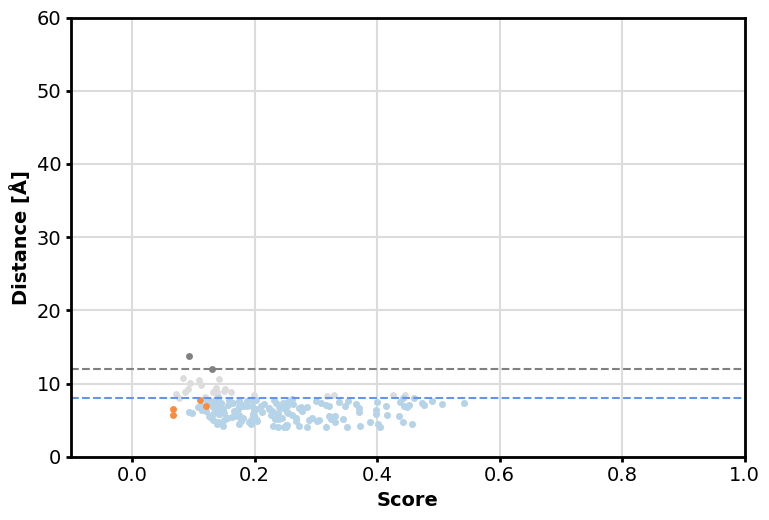

In [50]:
fig = plt.figure(figsize=(7.5, 5))
ax1 = fig.subplots()

#indexing for coloring - separate table into multimer contacts and monomer contacts
idx = tbl_cc['dist_intra']<=tbl_cc['dist_multimer']
tbl_monomer = tbl_cc[idx]
tbl_multimer = tbl_cc[~idx]

#threshold lines for distance threshold and cn-score threshold
ax1.axhline(y=dist_thresh, color="cornflowerblue", linestyle='--', linewidth=1.5)
ax1.axhline(y=dist_thresh_large, color="grey", linestyle='--', linewidth=1.5)

#index based on distance threshold to color
idx_dist_thresh_monomer = tbl_monomer['dist']<=dist_thresh
idx_unsatisfied_monomer = tbl_monomer['dist']>dist_thresh_large

idx_dist_thresh_multimer = tbl_multimer['dist']<=dist_thresh
idx_unsatisfied_multimer = tbl_multimer['dist']>dist_thresh_large

# scatter plots for couplings, cn-score vs. distance
ax1.scatter(tbl_cc['Score'],
           tbl_cc['dist'], s=15, c="gainsboro")

s1 = ax1.scatter(tbl_monomer[idx_dist_thresh_monomer]['Score'],
            tbl_monomer[idx_dist_thresh_monomer]['dist'], 
           s=15, c="#b6d4e9")
s5 = ax1.scatter(tbl_monomer[idx_unsatisfied_monomer]['Score'],
            tbl_monomer[idx_unsatisfied_monomer]['dist'], 
           s=15, c="grey")

s2 = ax1.scatter(tbl_multimer[idx_dist_thresh_multimer]['Score'],
            tbl_multimer[idx_dist_thresh_multimer]['dist'], 
           s=15, c="#fc8c3b")
s6 = ax1.scatter(tbl_multimer[idx_unsatisfied_multimer]['Score'],
            tbl_multimer[idx_unsatisfied_multimer]['dist'], 
           s=15, c="grey")


# some custom gusto with the axis labelling
# some custom gusto with the axis labelling
ax1.set_xlabel('Score', fontsize = 14, fontweight = 'bold')
ax1.set_ylabel('Distance CB-CB [Å]', fontsize = 14, fontweight = 'bold')
ax1.grid(True, which='major', linewidth = 1.5, color = 'gainsboro')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_axisbelow(True)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
# increase tick width
ax1.tick_params(width=2)

ax1.set_xlim(-0.1,1)
ax1.set_ylim(0,60)

fig.tight_layout(pad = 0, h_pad = 0, w_pad = 0) # tight padding in plot, no big gaps

plt.show()